<a href="https://colab.research.google.com/github/sandeepthetechie/mastering_the_art_of_tensorflow/blob/master/Transfer_learning_with_TF_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning. 

In [1]:
# Downloading the data. 
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-09-17 10:34:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  62.4MB/s    in 2.6s    

2021-09-17 10:34:51 (62.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are 2 directories and 0 files in 10_food_classes_10_percent
There are 10 directories and 0 files in 10_food_classes_10_percent/train
There are 0 directories and 75 files in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 files in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 files in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 files in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 files in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 files in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 files in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 files in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 files in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 files in 10_food_classes_10_percent/train/ice_cream
There are 10 directories and 0 fi

## Creating Data loaders

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size = IMAGE_SHAPE, 
                                                          batch_size = BATCH_SIZE, 
                                                          class_mode = "categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir, 
                                             target_size = IMAGE_SHAPE, 
                                             batch_size = 32, 
                                             class_mode ="categorical")


Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


# Setting up tensorboard call back. 

In [4]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorflow logs to {log_dir}.')
  return tensorboard_callback

In [5]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [6]:
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
def create_model(model_url, num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable = False, 
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,))
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])

  return model
  

In [8]:
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ["accuracy"])


In [11]:
resnet_history = resnet_model.fit(train_data_10_percent, 
                                  epochs = 5, 
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data, 
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                               experiment_name = "resnet50V2")])

Saving Tensorflow logs to tensorflow_hub/resnet50V2/20210917103507.
Epoch 1/5
24/24 [==============================] - 55s 1s/step - loss: 1.9277 - accuracy: 0.3333 - val_loss: 1.2146 - val_accuracy: 0.6176
Epoch 2/5
24/24 [==============================] - 22s 938ms/step - loss: 0.8886 - accuracy: 0.7400 - val_loss: 0.8451 - val_accuracy: 0.7356
Epoch 3/5
24/24 [==============================] - 22s 941ms/step - loss: 0.6075 - accuracy: 0.8280 - val_loss: 0.7715 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 22s 937ms/step - loss: 0.4728 - accuracy: 0.8787 - val_loss: 0.7066 - val_accuracy: 0.7756
Epoch 5/5
24/24 [==============================] - 22s 935ms/step - loss: 0.3703 - accuracy: 0.9200 - val_loss: 0.6762 - val_accuracy: 0.7804


# Plotting curves. 

In [12]:
from matplotlib import pyplot as plt

def plot_loss_curve(history):
  """
  Returns separate loss curve for training and validation metrics 

  Args: 
    history: Tensorflow History object
  
  Returns: 
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend

  # Plot accuracy

  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

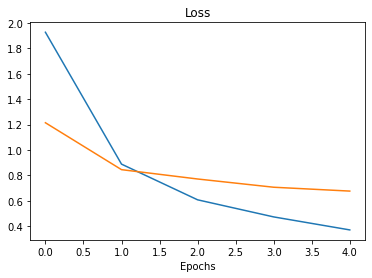

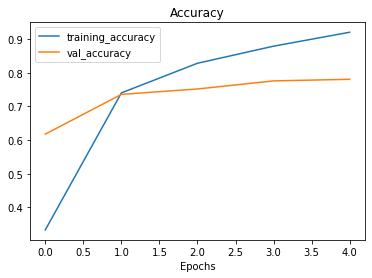

In [13]:
plot_loss_curve(resnet_history)

# Creating and testing efficientnet. 

In [17]:
efficientnet_model = create_model(model_url = efficientnet_url, 
                                  num_classes = len(train_data_10_percent))

efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(), 
                           metrics = ["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data, 
                                              validation_steps = len(test_data), 
                                              callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                       experiment_name = "efficientnetb0")])

Saving Tensorflow logs to tensorflow_hub/efficientnetb0/20210917104154.


InvalidArgumentError: ignored

In [ ]:
plot_loss_curve(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 24)                30744     
Total params: 4,080,308
Trainable params: 30,744
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing models using tensorboard.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-09-17 10:42:03.047265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 10:42:03.072054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 10:42:03.072721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac